## EDA & RFM Analysis on the CDNOW Dataset 

This is based from data & analysis found in these notebooks:
https://github.com/datascienceinc/oreilly-intro-to-predictive-clv & https://github.com/datascienceinc/pydata-seattle-2017/blob/master/lifetime-value/pareto-nbd.ipynb

In [88]:
from __future__ import division, print_function
import os 
import sys 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime 
import lifetimes
from pymc3.math import exp, log

# from scipy.stats import gaussian_kde
# from hashlib import md5

%matplotlib inline 

## Dataset 

The dataset is the CDNOW dataset, the seminal dataset for CLV models, which can be found here: (http://www.brucehardie.com/datasets/)

It contains transactions for a CD retailer from 1996 to 1997 including the customer ID, the date, and the sales amount. It only contains customers that started purchasing in the first few months, so there is a dramatic "drop off" in sales after that catchment period as the dataset no longer includes "new" customers.

In [3]:
transactions = pd.read_csv('cdnow_transaction_log.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
print("There are {} transactions across {} customers,\nwith dates ranging from {} to {}".format(transactions.shape[0],
                                                                      transactions['cust'].nunique(),
                                                                      transactions['date'].min(),
                                                                      transactions['date'].max()))
transactions.head()

There are 6695 transactions across 2357 customers,
with dates ranging from 1997-01-01 00:00:00 to 1998-06-30 00:00:00


,cust,date,sales
0,4,1997-01-18,29.73
1,4,1997-08-02,14.96
2,4,1997-12-12,26.48
3,18,1997-01-04,14.96
4,21,1997-01-01,63.34


## Exploratory Data Analysis

Below are some statistics and visualisations that explore the transaction patterns of these customers, important things to note are that:

* Around half of the individuals only make one purchase
* The visits /total spend distributions are negatively skewed - lots of people make a few smaller purchases and only a few people make lots of large purchases

In [4]:
transactions['week'] = transactions['date'].dt.year*100 + transactions['date'].dt.week
week_summary = transactions.groupby(['cust', 'week']).sum()
week_summary = week_summary.reset_index()
week_summary = week_summary.pivot(index='cust', columns='week').fillna(0)

In [5]:
transactions['previous_visit'] = transactions.groupby(['cust'])['date'].shift()
transactions['days_bw_visits'] = (transactions['date'] - transactions['previous_visit']).apply(lambda x: x.days)

In [6]:
latest_dates = transactions.groupby(['cust'])['date'].max()

In [7]:
cust_df = pd.DataFrame()

cust_df['M_Total Spend'] = transactions.groupby(['cust'])['sales'].sum()
cust_df['M_Average Weekly Spend'] = week_summary.mean(axis=1)
cust_df['M_Average Spend'] = transactions.groupby(['cust'])['sales'].mean()

cust_df['F_Total Visits'] = transactions.groupby(['cust'])['sales'].count()
cust_df['F_Average Time Between Purchases'] = transactions.groupby(['cust'])['days_bw_visits'].mean()
cust_df['F_Single Visit Only'] = cust_df['F_Average Time Between Purchases'].apply(lambda x: 0 if x > 0 else 1)

cust_df['R_Time Since Last Visit'] = (latest_dates.max() - latest_dates).dt.days

In [8]:
stats_df = pd.DataFrame(cust_df.agg(['sum', 'min', 'median', 'mean', 'max'])).T
stats_df

,sum,min,median,mean,max
M_Total Spend,244062.610000,0.0,43.060000,103.547989,6552.70000
M_Average Weekly Spend,3089.400127,0.0,0.545063,1.310734,82.94557
M_Average Spend,77749.864024,0.0,25.403333,32.986790,506.97000
F_Total Visits,6695.000000,1.0,1.000000,2.840475,44.00000
F_Average Time Between Purchases,127749.107703,1.0,79.000000,112.159006,532.00000
F_Single Visit Only,1218.000000,0.0,1.000000,0.516759,1.00000
R_Time Since Last Visit,875776.000000,0.0,473.000000,371.563852,545.00000


In [19]:
def plot_hist_and_scatter(cust_df, column):
    figure = cust_df[column].hist(bins=100, color="#3b658e", edgecolor='black', figsize=(10,10))
    figure.set_xlabel(column.split("_")[1])
    figure.set_ylabel("Number of Individuals")
    figure.grid(b=None)
    ylocs = figure.get_yticks()
    figure.scatter(x=cust_df[column], y=np.random.uniform(-1*int(ylocs.max()/5),
                                                           -1*int(ylocs.max()/10),
                                                           len(cust_df[column])),
                   marker='o', alpha=0.4,
                   linewidth='1',
                   color="#3b658e",
                   edgecolors="#021e49")

    for label in figure.get_yticklabels()[0:2]:
        label.set_visible(False)

    figure.spines['top'].set_visible(False)
    figure.spines['right'].set_visible(False)
    figure.spines['bottom'].set_visible(False)
    figure.spines['bottom'].set_position('zero')

    figure.spines['left'].set_visible(False)
    return figure

## Frequency

99.92%  of customers have >= 1   0.08%   of customers have < 1
99.87%  of customers have >= 2   0.13%   of customers have < 2
99.66%  of customers have >= 3   0.34%   of customers have < 3
99.41%  of customers have >= 4   0.59%   of customers have < 4
99.24%  of customers have >= 5   0.76%   of customers have < 5
99.02%  of customers have >= 6   0.98%   of customers have < 6
98.85%  of customers have >= 7   1.15%   of customers have < 7
98.60%  of customers have >= 8   1.40%   of customers have < 8
98.43%  of customers have >= 9   1.57%   of customers have < 9


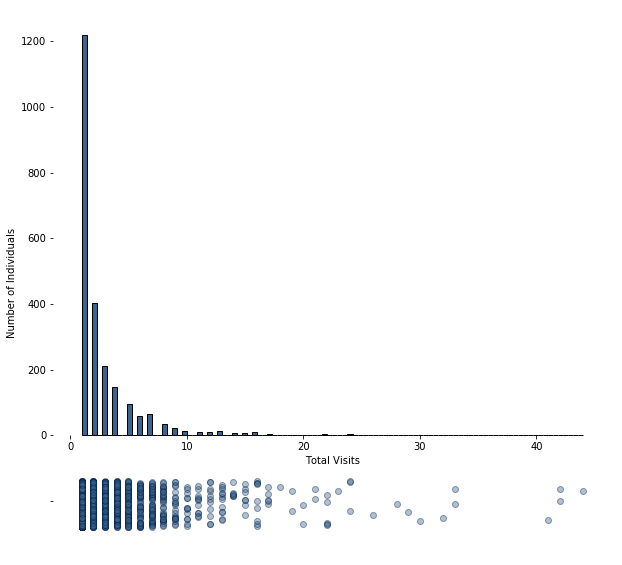

In [20]:
plot_hist_and_scatter(cust_df, 'F_Total Visits')
    
    
for val in range(1,10):
    print("{: <7,.2%} of customers have >= {}".format(
         cust_df[cust_df[column] >= val].shape[0] / cust_df.shape[0],
         val), end="   ")
    print("{: <7,.2%} of customers have < {}".format(
         cust_df[cust_df[column] < val].shape[0] / cust_df.shape[0],
        val))

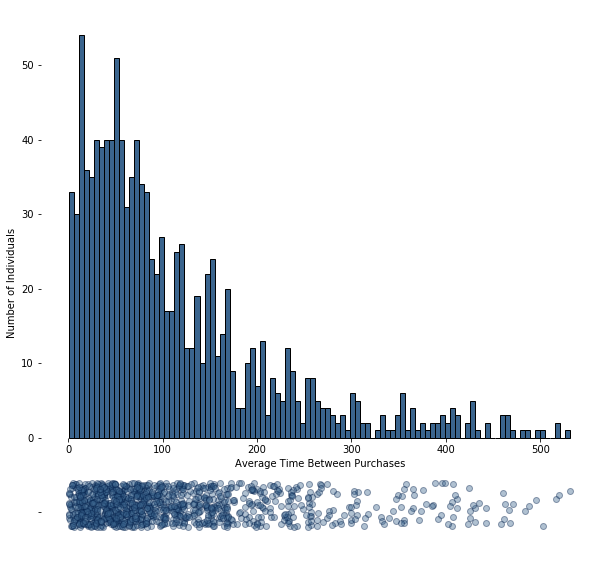

In [21]:
plot_hist_and_scatter(cust_df, 'F_Average Time Between Purchases')

## Recency

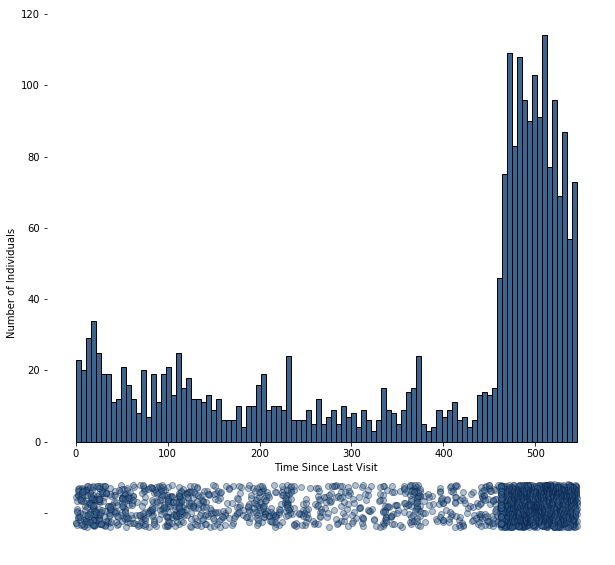

In [23]:
plot_hist_and_scatter(cust_df, 'R_Time Since Last Visit')

## Monetary

<Figure size 432x288 with 0 Axes>

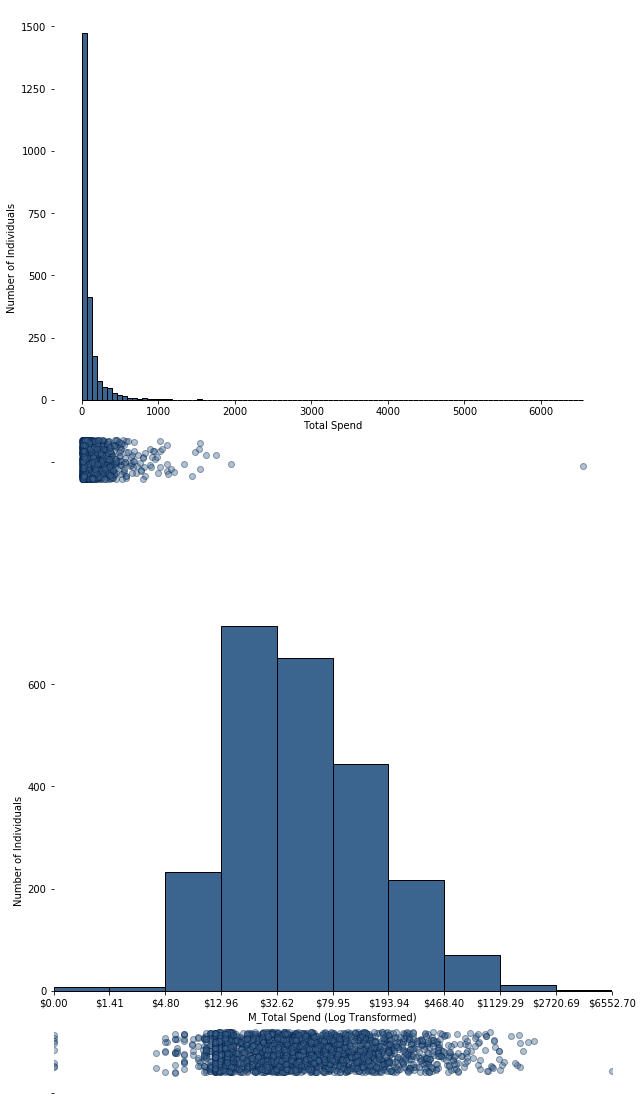

In [24]:
plt.clf();
column = 'M_Total Spend';
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,20));

cust_df[column].hist(ax=axes[0], bins=100, color="#3b658e", edgecolor='black');
cust_df[column].apply(lambda x: np.log(1 + x)).hist(ax=axes[1], color="#3b658e", edgecolor='black', bins=10);
axes[0].set_xlabel(column.split("_")[1])
axes[0].set_ylabel("Number of Individuals")
axes[0].grid(b=None)
ylocs = axes[0].get_yticks()
axes[0].scatter(x=cust_df[column], y=np.random.uniform(-1*int(ylocs.max()/5),
                                                       -1*int(ylocs.max()/10),
                                                       len(cust_df[column])),
               marker='o', alpha=0.4,
               linewidth='1',
               color="#3b658e",
               edgecolors="#021e49")

for label in axes[0].get_yticklabels()[0:2]:
    label.set_visible(False)

axes[0].spines['left'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['bottom'].set_position('zero')

axes[1].set_xlabel("{} (Log Transformed)".format(column.replace("value_","")))
axes[1].set_ylabel("Number of Individuals")
max_log = cust_df[column].apply(lambda x: np.log(1 + x)).max()
axes[1].set_xlim([0, max_log])

locs = np.linspace(0, max_log, 11)
axes[1].set_xticks(locs)
labels = pd.Series(locs).apply(lambda x: "${:.2f}".format(np.exp(x) - 1))
axes[1].set_xticklabels(labels)
axes[1].grid(b=None)

axes[1].spines['left'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['bottom'].set_position('zero')

for ax in axes:
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    
ylocs = axes[1].get_yticks()
axes[1].scatter(x=cust_df[column].apply(lambda x: np.log(1 + x)),
                y=np.random.uniform(-1*int(ylocs.max()/5),
                                                       -1*int(ylocs.max()/10),
                                                       len(cust_df[column])),
               marker='o', alpha=0.4,
               linewidth='1',
               color="#3b658e",
               edgecolors="#021e49")

for label in axes[1].get_yticklabels()[0:2]:
    label.set_visible(False)

# for value in cust_df[column].quantile([0,0.05, .25, 0.5,.75, 0.95, 1]):
#     print("{: <7,.2%} of customers have >= {:<10,.2f}".format(
#          cust_df[cust_df[column] >= value].shape[0] / cust_df.shape[0],
#          value ), end="   ")
#     print("{: <7,.2%} of customers have < {:<10,.2f}".format(
#          cust_df[cust_df[column] < value].shape[0] / cust_df.shape[0],
#          value))
    
# stats_df.loc[column]

#Todo: Add mean onto scatterplot

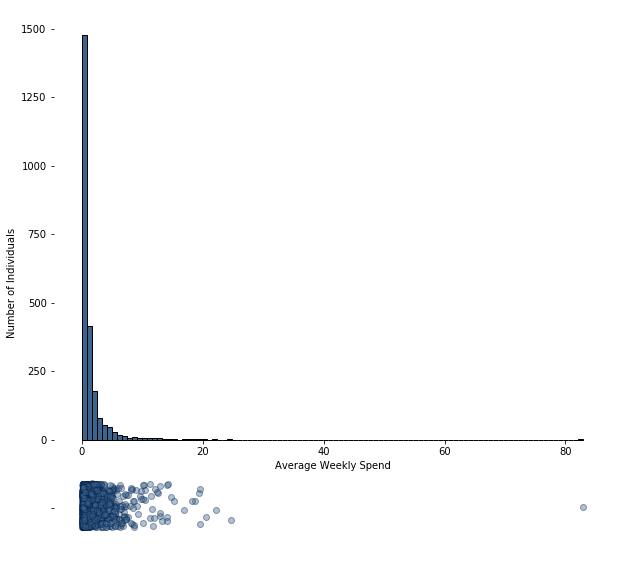

In [25]:
plot_hist_and_scatter(cust_df, 'M_Average Weekly Spend')

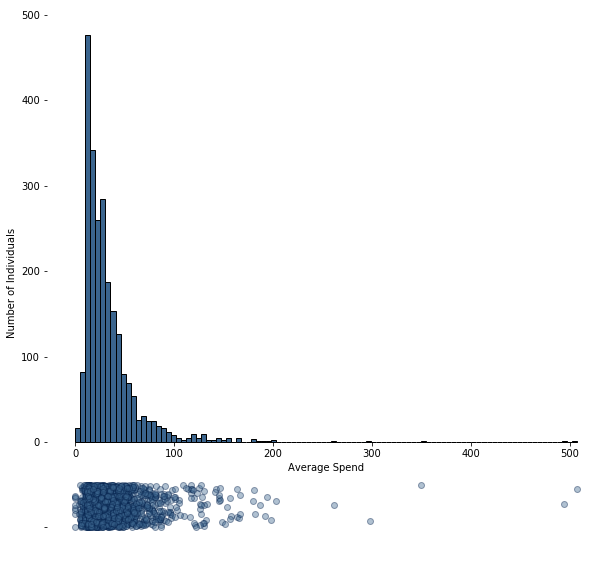

In [26]:
plot_hist_and_scatter(cust_df, 'M_Average Spend')

## Weekly RFM Plots

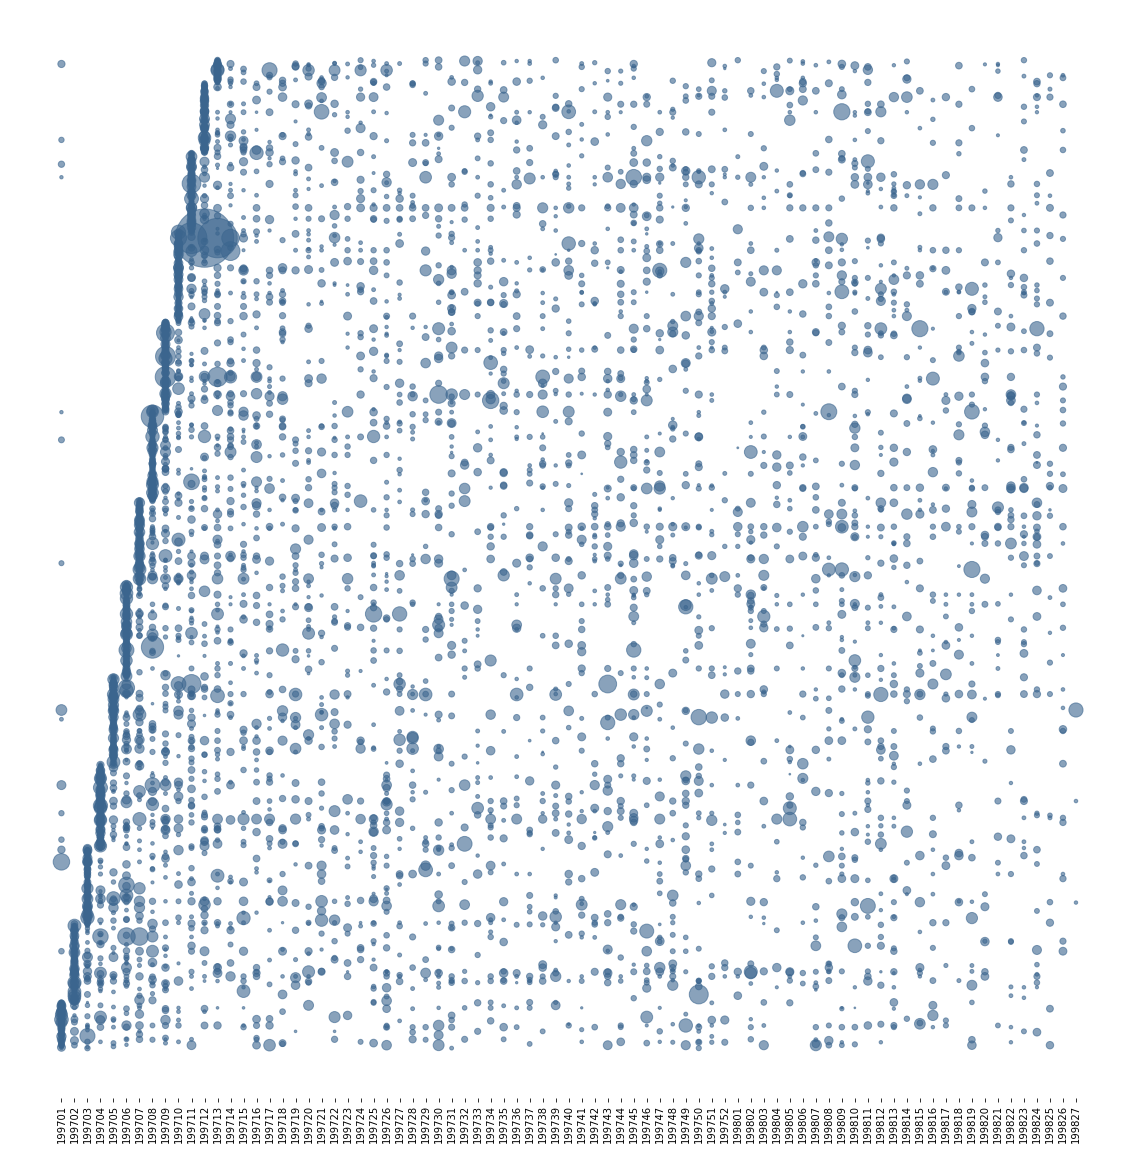

In [27]:
##to do: order by R, F and M
melted_ws = pd.melt(week_summary.reset_index().reset_index(), id_vars = ['index','cust'])
melted_ws = melted_ws[melted_ws['value'] != 0.0]
fig = plt.figure(figsize=(20,20))
plt.scatter(y=melted_ws['index'],
            x=melted_ws['week'].astype(str), 
            s=melted_ws['value'],
            color = "#3b658e",
            alpha=0.6)
plt.xticks(rotation=90)
plt.yticks([])
plt.box(on=None)
plt.show()

# Part 2 - CLV Calculations

## Calculate CLV using the lifetimes package

Train a Beta Geometric Model, and estimate the global parameters

In [65]:
rfm = lifetimes.utils.summary_data_from_transaction_data(
    transactions,
    'cust',
    'date',
    observation_period_end=pd.to_datetime('1997-09-30'),
    freq='W'
)
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0) #or BetaGeoBetaBinomFitter
                                                  #or ParetoNBDFitter
                                                  #or ModifiedBetaGeoFitter
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.290848,0.016502,0.258504,0.323192
alpha,6.849846,0.603467,5.667050,8.032642
a,0.662243,0.190081,0.289684,1.034803
b,2.301891,0.795040,0.743613,3.860169


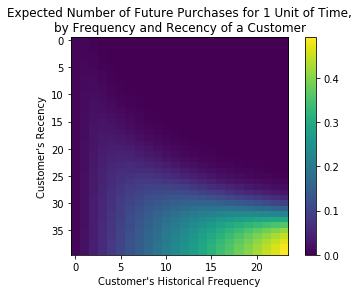

In [66]:
lifetimes.plotting.plot_frequency_recency_matrix(bgf); # lifetimes.plotting.plot_probability_alive_matrix(bgf);

In [46]:
outputs = rfm.copy()
outputs['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(10,
                                                                                         outputs['frequency'],
                                                                                         outputs['recency'],
                                                                                         outputs['T'])
outputs.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
cust,,,,
19060,13.0,30.0,30.0,3.202218
3041,14.0,30.0,31.0,3.302521
5420,16.0,35.0,36.0,3.372164
20111,16.0,29.0,29.0,4.052771
1760,23.0,37.0,38.0,4.656373


Then train a Gamma Gamme Model for the monetary value, and estimate the global parameters

In [77]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
if returning_customers_summary[['monetary_value', 'frequency']].corr().values[0][1] > 0.7:
    print("Not likely to be viable as correlation is too high")
summary_with_money_value = lifetimes.datasets.load_cdnow_summary_data_with_monetary_value() #TODO:change to correct cust id
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


Then produce estimates for each individual for the time periods

In [86]:
##Provide Estimates of CLV
ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=1, # months
    discount_rate=0.01).head(10)

customer_id
1      24.597643
2       4.067584
6     203.629955
7       5.386869
9      29.058440
11     49.957487
17    119.660462
18      4.986647
19     36.379814
21     20.344904
Name: clv, dtype: float64

## Calculate CLV using pymc3

In [ ]:
class ParetoNBD(pm.Continuous):
    """
    Custom distribution class for Pareto/NBD likelihood.
    """
    
    def __init__(self, lambda_, mu, *args, **kwargs):
        super(ParetoNBD, self).__init__(*args, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        
    def logp(self, x, t_x, T):
        """
        Loglikelihood function for and indvidual customer's purchasing rate \lambda
        and lifetime \mu given their frequency, recency and time since first purchase.
        """
        
        log_lambda = log(self.lambda_)
        log_mu = log(self.mu)
        mu_plus_lambda = self.lambda_ + self.mu
        log_mu_plus_lambda = log(mu_plus_lambda)
        
        p_1 = x * log_lambda + log_mu - log_mu_plus_lambda - t_x * mu_plus_lambda
        p_2 = (x + 1) * log_lambda - log_mu_plus_lambda - T * mu_plus_lambda
        
        return log(exp(p_1) + exp(p_2))

# Part 3 - Goodness of Fit comparisons

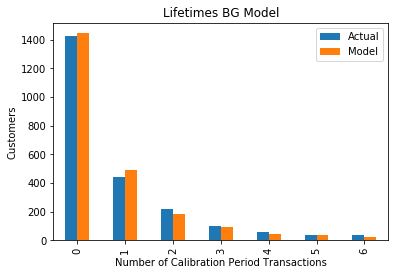

In [68]:
lifetimes.plotting.plot_period_transactions(bgf, title="Lifetimes BG Model")